# Loss and Metrics

## Abstract

In this notebook we will discuss ``LossMetrics`` lens and its applications for text classification.

## Imports and Dataset

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

warnings.simplefilter("ignore")

from torchvision import transforms
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

warnings.simplefilter("default")

from sklearn.model_selection import train_test_split

RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

For this task we will use [Ecommerce Text Classification](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) dataset. It contains class of an item (**Electronics**, **Household**, **Books** and **Clothing & Accessories**) and its description.

In [2]:
df = pd.read_csv("ecommerceDataset.csv", header=None, names=["label", "text"]).fillna("")
Xtrain, Xval, ytrain, yval = train_test_split(
    df.text, df.label, shuffle=True, random_state=RND_SEED, test_size=0.2
)
df.sample(5, random_state=RND_SEED)

,label,text
35848,Clothing & Accessories,Kandy Men's Regular Fit Blazer Blue This produ...
13005,Household,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...
22719,Books,Concept of Physics (2018-2019) Session (Set of...
18453,Household,Lista Stainless Steel Multi Functional Hammer ...
20867,Books,Gardening in Urban India update


We will use ``torchtext`` utilities to tokenize dataset and encode each word as its index in vocabluary with 10K words. Each description then will be either padded or truncated to be 32 tokens long, it will make the data to be ready to use.

In [3]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(text_iter):
    for text in text_iter:
        yield tokenizer(text)

MAX_TOKENS = 10000
vocab = build_vocab_from_iterator(
    yield_tokens(Xtrain.values),
    specials=[ "<pad>", "<unk>"],
    max_tokens=MAX_TOKENS
)
vocab.set_default_index(vocab["<unk>"])

MAX_LEN = 32
PAD_IDX = vocab["<pad>"]

def encode(text):
    tokens = tokenizer(text)
    ids = vocab(tokens)
    if len(ids) < MAX_LEN:
        ids += [PAD_IDX] * (MAX_LEN - len(ids))
    else:
        ids = ids[:MAX_LEN]
    return ids

Xtrain_ids = torch.tensor([encode(t) for t in Xtrain], dtype=torch.long)
Xval_ids = torch.tensor([encode(t) for t in Xval], dtype=torch.long)

label_to_idx = {label: i for i, label in enumerate(sorted(df.label.unique()))}
ytrain_ids = torch.tensor([label_to_idx[l] for l in ytrain], dtype=torch.long)
yval_ids = torch.tensor([label_to_idx[l] for l in yval], dtype=torch.long)

BATCH_SIZE = 32
train_ds = TensorDataset(Xtrain_ids, ytrain_ids)
val_ds = TensorDataset(Xval_ids, yval_ids)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

## Neural Network Definition

For this task we will embded each token into a 32 dimensional space, than take a mean embeding over all tokens in a text and pass it through a two layer neural net with ReLU activations and softmax output.

In [4]:
class TextClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        global MAX_TOKENS, PAD_IDX, label_to_idx
        super().__init__()
        self.embedder = nn.Embedding(
            MAX_TOKENS, embedding_dim, padding_idx=PAD_IDX
        )
        self.lin1 = nn.Linear(embedding_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, len(label_to_idx))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        embedding = self.embedder(X).mean(dim=1)
        t = torch.relu(self.lin1(embedding))
        return self.softmax(self.lin2(t))

We will also define an early stopping mechanism for regularization.

In [5]:
class EarlyStopper:
    def __init__(self, patience : int = 5, eps : float = 1e-3):
        self.loss = float('+inf')
        self.timer = 0
        self.eps = eps
        self.patience = patience

    def __call__(self, new_loss : float) -> bool:
        if self.loss - new_loss > self.eps:
            self.loss = new_loss
            self.timer = 0
            return False
        self.timer += 1
        return self.timer >= self.patience

## Explicit Loss saving

``LossMetrics`` from ``monitorch.lens`` is designed to be a drop in loss recording tool. During its initialization user may define what aggregations will be used by providing ``loss_line`` and ``loss_ranges`` parameters. To display custom metrics they must be declared to a lens during initialization, their aggregations can be tweaked the same way the loss are done by changing ``metrics_line`` and ``metrics_ranges``.

The lens allows two ways to record loss, one through an explicit call on inspector and another one by providing loss function module to the lens. The first one feels more natural so, we will start with that. To save loss one needs to call ``push_loss`` on an inspector and provide whether the loss is training or not. There is a symmetric method for metrics ``push_metric`` that also requries to provide name of the metric pushed. Both of them can be tweaked by optional flag ``running`` to be in-place (default) or in-memory. 

In [6]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics

inspector = PyTorchInspector(
    lenses = [LossMetrics(
        loss_line='median',
        loss_range=['Q1-Q3'],
        metrics = ['val_accuracy']
    )]
)

Let us train a neural net with 16 hidden neurons using stochastic gradient descent. To obtain a validation loss from last finished epoch one could use ``loss(train=False)`` on the lens object, that way it can be provided to our early stopper.

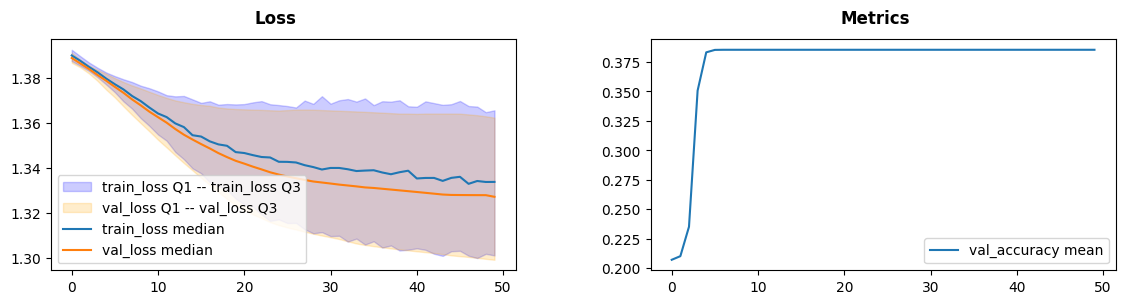

In [7]:
model = TextClassifier(32, 16)
stopper = EarlyStopper()

inspector.attach(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001
)

N_EPOCH = 50
for epoch in range(N_EPOCH):

    # Train
    for data, label in train_loader:
        pred = model(data)
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        inspector.push_loss(loss.item(), train=True, running=False) # pushing training loss

    # Validation
    correctly_classified = 0

    with torch.no_grad():
        for data, label in val_loader:
            pred = model(data)
            loss = loss_fn(pred, label)
            inspector.push_loss(loss.item(), train=False, running=False) # pushing validation loss
            correctly_classified += pred.argmax(dim=1).eq(label).float().sum().item()
    
    inspector.push_metric('val_accuracy', correctly_classified / Xval.shape[0]) # pushing validation accuracy
    
    inspector.tick_epoch()
    if stopper(inspector.lenses[0].loss(train=False)): # extracting validation loss from lens
        break
    
fig = inspector.visualizer.show_fig()

## Automatic Loss Saving

Another option is to provide a loss function to the lens during initialization, this way no explicit calls must be made. Nevertheless, for the loss to be recorded it must be firstly computed. Training requires a loss to backpropagate through, so training pass is not changed, but we need to compute loss in a validation pass, inspite that it is not used anywhere explicitly. Loss function module cannot be disconnected from lens withour direct interegation, so ``detach`` and ``attach`` calls can be done without reattaching loss function.

With those thoughts in mind we can define simple functions for training and leave all of the tracing for the inspector and lenses, making our code more expressive.

In [8]:
def train_one_epoch(model, loss_fn, optimizer, dataloader=train_loader):
    for data, label in dataloader:
        pred = model(data)
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

@torch.no_grad
def validate_one_epoch(model, loss_fn, dataloader=val_loader, n_val=Xval.shape[0]):
    correctly_classified = 0
    for data, label in dataloader:
        pred = model(data)
        loss = loss_fn(pred, label)
        correctly_classified += pred.argmax(dim=1).eq(label).float().sum().item()
    return correctly_classified / n_val

Below we redefine inspector to record loss from loss function.

In [9]:
loss_fn = nn.CrossEntropyLoss()

inspector = PyTorchInspector(
    lenses = [LossMetrics(
        loss_fn=loss_fn,
        loss_fn_inplace=False,
        loss_line='median',
        loss_range=['Q1-Q3'],
        metrics = ['val_accuracy']
    )]
)

We will now train the very same network to be sure about equivalence of both tracking methods.

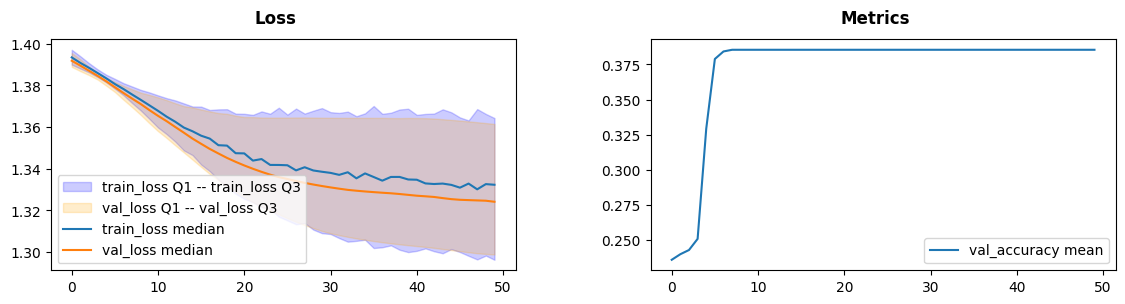

In [10]:
model = TextClassifier(32, 16)
stopper = EarlyStopper()

inspector.attach(model)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001
)

N_EPOCH = 50
for epoch in range(N_EPOCH):
    train_one_epoch(model, loss_fn, optimizer)
    val_acc = validate_one_epoch(model, loss_fn)
    
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    
    if stopper(inspector.lenses[0].loss(train=False)):
        break
fig = inspector.visualizer.show_fig()

Training slows after 30 epochs, that can be either a problem of a net being too shallow or a problem of our training procedure.

Lastly we will train our model with RMSprop optimizer to get better results.

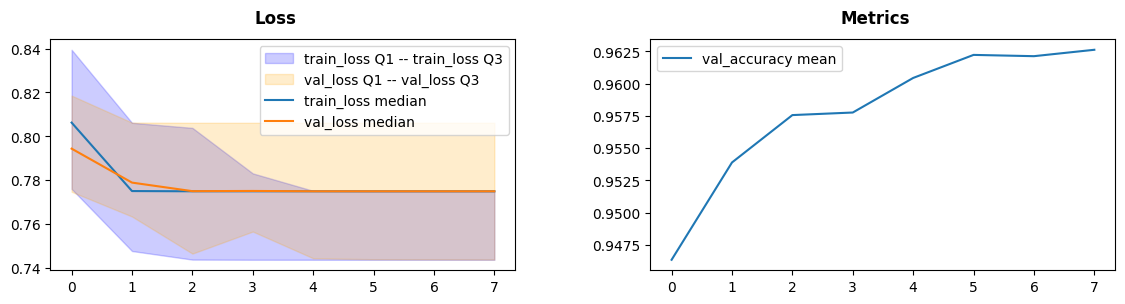

In [11]:
model = TextClassifier(32, 16)
stopper = EarlyStopper()

inspector.attach(model)
optimizer = torch.optim.RMSprop(
    model.parameters()
)

N_EPOCH = 50
for epoch in range(N_EPOCH):
    train_one_epoch(model, loss_fn, optimizer)
    val_acc = validate_one_epoch(model, loss_fn)
    
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    
    if stopper(inspector.lenses[0].loss(train=False)):
        break
fig = inspector.visualizer.show_fig()

RMSprop was able to learn the data quick (7 epochs) with 96% accuracy we call it a success.

## What to Look for
* Loss plateaus are generally a sign of a problem with one of the parts of the procedure
* Too much variance in training loss could signal gradient issues (see ``GradientGeometry`` for that)
  
## Next steps

* Try ``LossMetrics`` for training your neural networks on other datasets.
* Take a look at other demonstration notebooks and documentation.
* Find how complex losses behave, such as bounding box loss or a CTC loss.